In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import seaborn as sn

TensorFlow 1.x selected.


In [ ]:
train_data = pd.read_csv("./drive/MyDrive/DL - HW1 Practical/Q1_train.csv")
test_data = pd.read_csv("./drive/MyDrive/DL - HW1 Practical/Q1_test.csv")
X_train_data = train_data[train_data.columns[1:]]
print('X_train_data.shape:', X_train_data.shape)
y_train_data = train_data[['label']]
print('y_train_data.shape:', y_train_data.shape)
X_test_data = test_data[test_data.columns[1:]]
print('X_test_data.shape:', X_test_data.shape)
y_test_data = test_data[['label']]
print('y_test_data.shape:', y_test_data.shape)

X_train_data.shape: (27455, 784)
y_train_data.shape: (27455, 1)
X_test_data.shape: (7172, 784)
y_test_data.shape: (7172, 1)


A) Visualization

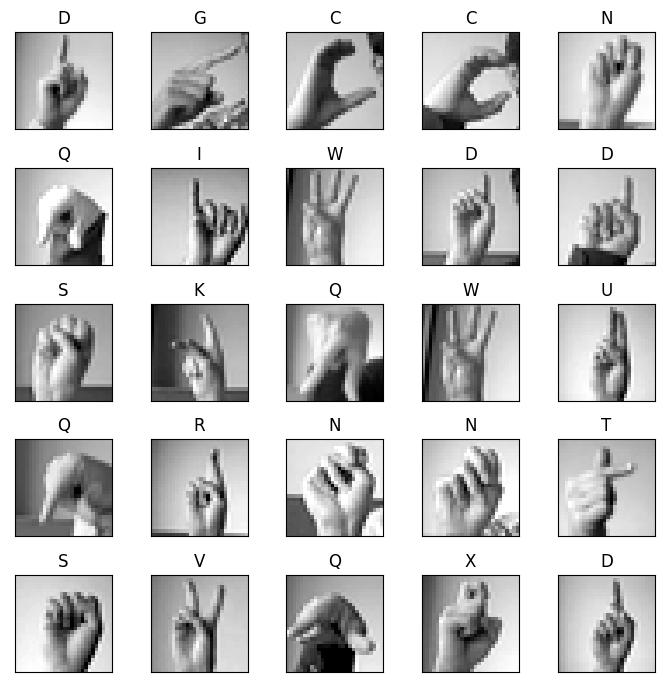

In [ ]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 100
fig = plt.figure()
for i in range(25):
  ax = fig.add_subplot(5, 5, i+1)
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
  ax.set_title(chr(65 + y_train_data.iloc[i]))
  temp = X_train_data.iloc[i].to_numpy()
  minimum = min(temp)
  maximum = max(temp)
  temp = (temp - minimum) / (maximum - minimum) * 255
  plt.imshow(temp.reshape(28, 28), cmap='gray')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

Preparation

In [ ]:
def weight_generator(name, shape, stddev):
  w = tf.get_variable(name='W_' + name, shape=shape, dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=stddev))
  w_tensorboard = tf.summary.histogram('W_' + name, w)
  return w

def bias_generator(name, shape):
  b = tf.get_variable(name='B_' + name, shape=shape, dtype=tf.float32, initializer=tf.zeros_initializer())
  b_tensorboard = tf.summary.histogram('B_' + name, b)
  return b
  
def FC(name, input, output_dimension, stddev=1.0, activation='Linear'):
  w = weight_generator(name, (input.get_shape()[1], output_dimension), stddev)
  b = bias_generator(name, output_dimension)
  z = tf.add(tf.matmul(input, w), b)
  if activation=='Tanh':
    output = tf.nn.tanh(z)
  elif activation=='Sigmoid':
    output = tf.nn.sigmoid(z)
  elif activation=='ReLU':
    output = tf.nn.relu(z)
  else:
    output = z
  return output

In [ ]:
number_of_pixels = 28 * 28
number_of_classes = 26

In [ ]:
random_number = np.random.randint(1e9)
temp_X = X_train_data.sample(frac=1, random_state=random_number)
temp_y = y_train_data.sample(frac=1, random_state=random_number)
X_train = temp_X.iloc[0:int(0.75*temp_X.shape[0])].reset_index(drop=True)
print('X_train.shape: ', X_train.shape)
y_train = temp_y.iloc[0:int(0.75*temp_y.shape[0])].reset_index(drop=True)
print('y_train.shape: ', y_train.shape)
X_validation = temp_X.iloc[int(0.75*temp_X.shape[0]):].reset_index(drop=True)
print('X_validation.shape: ', X_validation.shape)
y_validation = temp_y.iloc[int(0.75*temp_y.shape[0]):].reset_index(drop=True)
print('y_validation.shape: ', y_validation.shape)
X_test = X_test_data
print('X_test.shape:', X_test.shape)
y_test = y_test_data
print('y_test.shape:', y_test.shape)

X_train.shape:  (20591, 784)
y_train.shape:  (20591, 1)
X_validation.shape:  (6864, 784)
y_validation.shape:  (6864, 1)
X_test.shape: (7172, 784)
y_test.shape: (7172, 1)


In [ ]:
normalized_X_train = (X_train.to_numpy() - np.mean(X_train.to_numpy(), axis=0)) / (1e-3 + np.sqrt(np.var(X_train.to_numpy(), axis=0)))
normalized_X_validation = (X_validation.to_numpy() - np.mean(X_validation.to_numpy(), axis=0)) / (1e-3 + np.sqrt(np.var(X_validation.to_numpy(), axis=0)))
normalized_X_test = (X_test.to_numpy() - np.mean(X_test.to_numpy(), axis=0)) / (1e-3 + np.sqrt(np.var(X_test.to_numpy(), axis=0)))
with tf.Session() as sess:
  y_train_one_hot = sess.run(tf.one_hot(y_train['label'], number_of_classes))
  print('y_train_one_hot.shape: ', y_train_one_hot.shape)
  y_validation_one_hot = sess.run(tf.one_hot(y_validation['label'], number_of_classes))
  print('y_validation_one_hot.shape: ', y_validation_one_hot.shape)
  y_test_one_hot = sess.run(tf.one_hot(y_test['label'], number_of_classes))
  print('y_test_one_hot.shape: ', y_test_one_hot.shape)

y_train_one_hot.shape:  (20591, 26)
y_validation_one_hot.shape:  (6864, 26)
y_test_one_hot.shape:  (7172, 26)


B) SGD Optimizer

In [ ]:
number_of_pixels = 28 * 28
number_of_classes = 26
input_size = (None, number_of_pixels)
hidden_layer_1_size = 300
hidden_layer_2_size = 100
output_size = (None, number_of_classes)
minibatch_size = 2500
number_of_iterations = 1000

In [ ]:
SGD_constant_lr = 2
tf.reset_default_graph()
input = tf.placeholder(dtype=tf.float32, shape=input_size, name='Input')
FC1 = FC('FC1', input, hidden_layer_1_size, 0.1, 'Tanh')
FC2 = FC('FC2', FC1, hidden_layer_2_size, 0.1, 'Tanh')
output = FC('Output', FC2, number_of_classes, 0.1)
label = tf.placeholder(dtype=tf.float32, shape=output_size, name='Label')
loss = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=output, name='Loss'))
loss_tensorboard = tf.summary.scalar('Loss_tensorboard', loss)
lr = tf.placeholder(dtype=tf.float32, shape=(), name='Learning_Rate')
SGD_optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr, name='SGD_Optimizer').minimize(loss)
saver = tf.train.Saver()
with tf.Session() as sess:
  !rm -rf './drive/MyDrive/DL - HW1 Practical/graphs/SGD_Model'
  writer = tf.summary.FileWriter('./drive/MyDrive/DL - HW1 Practical/graphs/SGD_Model', sess.graph)
  summaries = tf.summary.merge_all()
  sess.run(tf.global_variables_initializer())
  for i in range(number_of_iterations):
    random_number = np.random.randint(1e9)
    temp_X = X_train.sample(n=minibatch_size, random_state=random_number)
    normalized_temp_X = (temp_X.to_numpy() - np.mean(temp_X.to_numpy(), axis=0)) / (1e-3 + np.sqrt(np.var(temp_X.to_numpy(), axis=0)))
    noisy_normalized_temp_X = normalized_temp_X + np.random.normal(0, 1, normalized_temp_X.shape)
    temp_y = y_train.sample(n=minibatch_size, random_state=random_number)
    temp_y_one_hot = sess.run(tf.one_hot(temp_y['label'], number_of_classes))
    sess.run(SGD_optimizer, feed_dict={input: noisy_normalized_temp_X, label: temp_y_one_hot, lr: SGD_constant_lr/(1+i/250)})
    if (i+1)%10==0:
      writer.add_summary(sess.run(summaries, feed_dict={input: normalized_X_train, label: y_train_one_hot}), global_step=(i+1)/10)
  saver.save(sess, './drive/MyDrive/DL - HW1 Practical/Saved Models/SGD_Model.ckpt')

INFO:tensorflow:Restoring parameters from ./drive/MyDrive/DL - HW1 Practical/Saved Models/SGD_Model.ckpt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


SGD Validation Accuracy =  1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


SGD Test Accuracy =  0.8399330730619075


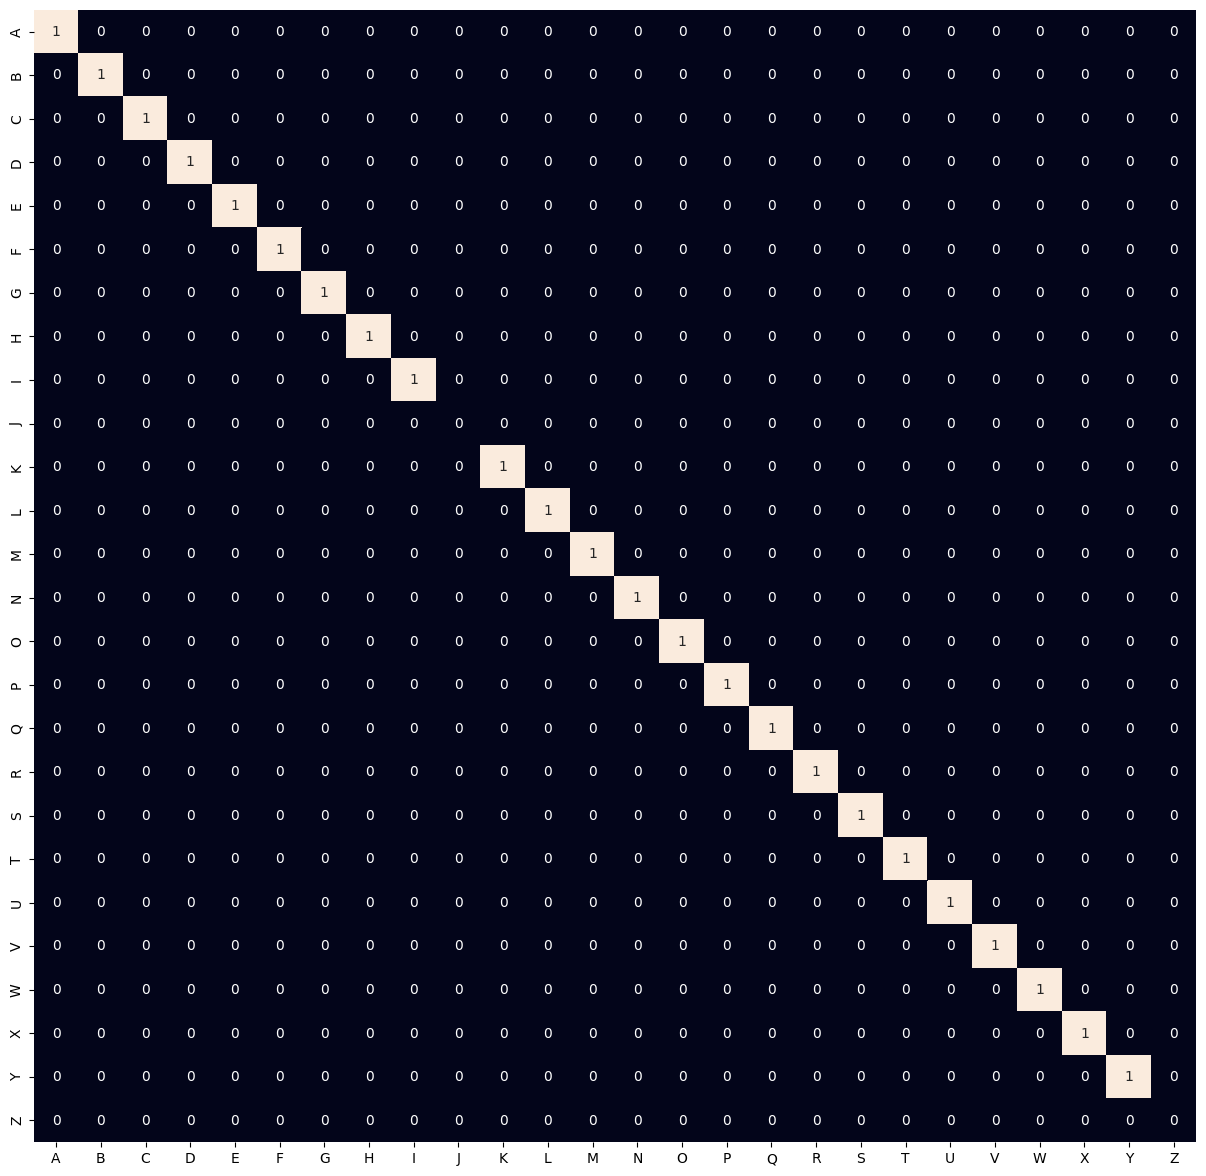

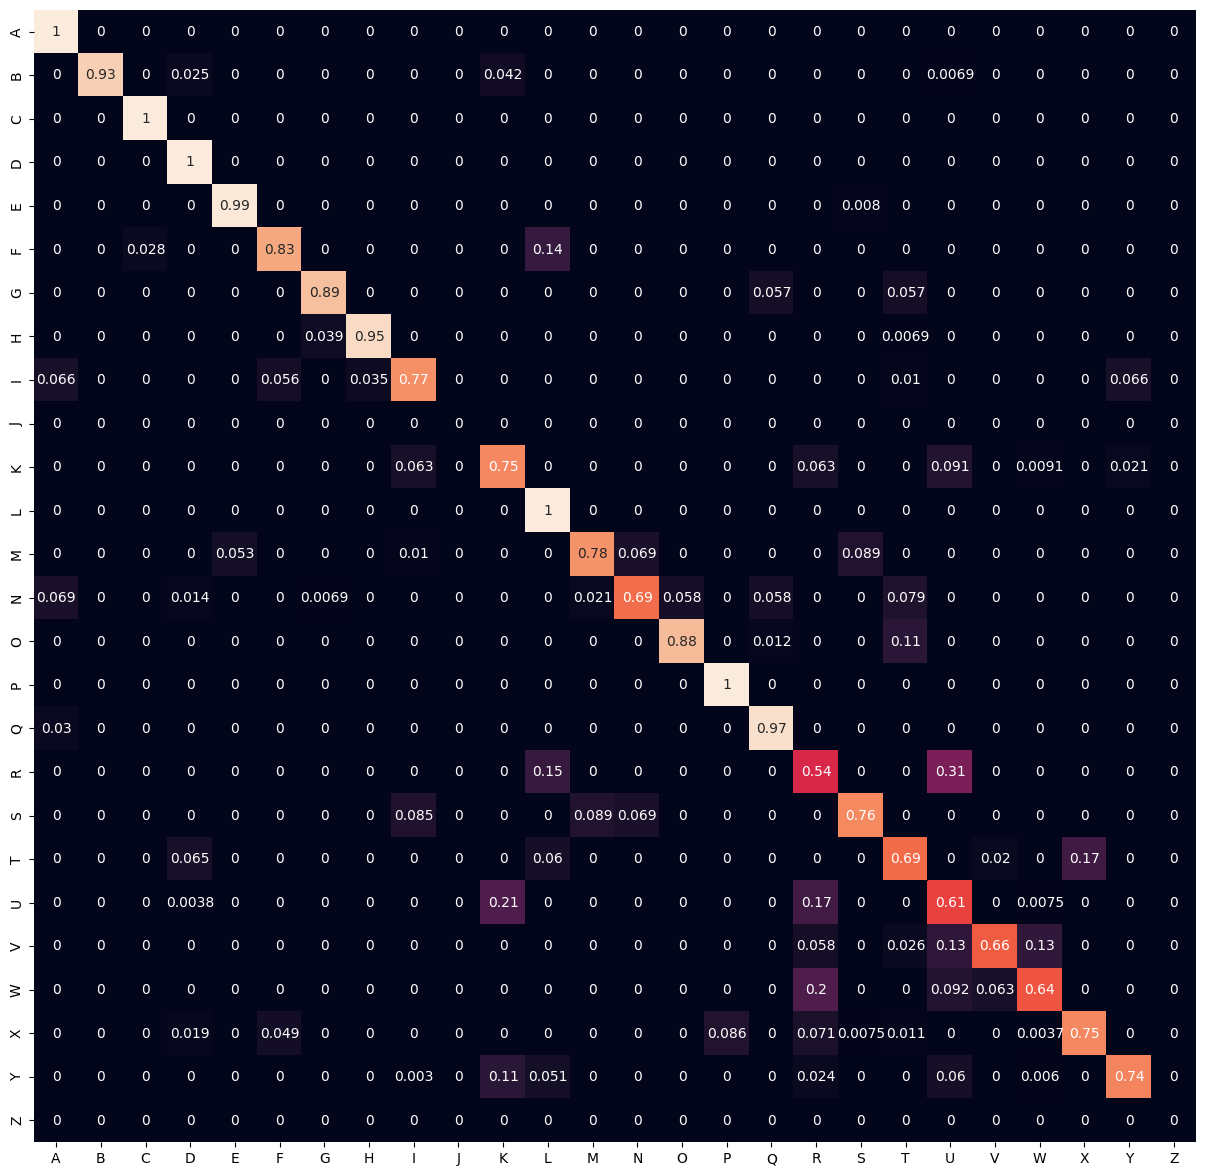

In [ ]:
tf.reset_default_graph()
input = tf.placeholder(dtype=tf.float32, shape=input_size, name='Input')
FC1 = FC('FC1', input, hidden_layer_1_size, 0.1, 'Tanh')
FC2 = FC('FC2', FC1, hidden_layer_2_size, 0.1, 'Tanh')
output = FC('Output', FC2, number_of_classes, 0.1)
label = tf.placeholder(dtype=tf.float32, shape=output_size, name='Label')
loss = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=output, name='Loss'))
lr = tf.placeholder(dtype=tf.float32, shape=(), name='Learning_Rate')  
SGD_optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr, name='SGD_Optimizer').minimize(loss)
saver = tf.train.Saver()
with tf.Session() as sess:
  saved_model_file = saver.restore(sess, './drive/MyDrive/DL - HW1 Practical/Saved Models/SGD_Model.ckpt')
  predicted_y_validation = np.argmax(sess.run(output, feed_dict={input: normalized_X_validation}), axis=1)
  validation_accuracy = np.mean(np.where(y_validation['label'].to_numpy()==predicted_y_validation, 1, 0))
  validation_confusion_matrix = tf.math.confusion_matrix(y_validation['label'].to_numpy(), predicted_y_validation, number_of_classes).eval().astype(np.float64)
  validation_confusion_matrix /= validation_confusion_matrix.sum(axis=1)[:,np.newaxis]
  validation_confusion_matrix = np.where(np.isnan(validation_confusion_matrix), 0, validation_confusion_matrix)
  df = pd.DataFrame(validation_confusion_matrix, index = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"], columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"])
  plt.figure(figsize=(15, 15))
  sn.heatmap(df, annot=True, cbar=False)
  print('SGD Validation Accuracy = ', validation_accuracy)
  predicted_y_test = np.argmax(sess.run(output, feed_dict={input: normalized_X_test}), axis=1)
  test_accuracy = np.mean(np.where(y_test['label'].to_numpy()==predicted_y_test, 1, 0))
  test_confusion_matrix = tf.math.confusion_matrix(y_test['label'].to_numpy(), predicted_y_test, number_of_classes).eval().astype(np.float64)
  test_confusion_matrix /= test_confusion_matrix.sum(axis=1)[:,np.newaxis]
  test_confusion_matrix = np.where(np.isnan(test_confusion_matrix), 0, test_confusion_matrix)
  df = pd.DataFrame(test_confusion_matrix, index = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"], columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"])
  plt.figure(figsize=(15, 15))
  sn.heatmap(df, annot=True, cbar=False)
  print('SGD Test Accuracy = ', test_accuracy)

B) Adam Optimizer

In [ ]:
number_of_pixels = 28 * 28
number_of_classes = 26
input_size = (None, number_of_pixels)
hidden_layer_1_size = 300
hidden_layer_2_size = 100
output_size = (None, number_of_classes)
minibatch_size = 2500
number_of_iterations = 1000

In [ ]:
adam_constant_lr = 0.01
tf.reset_default_graph()
input = tf.placeholder(dtype=tf.float32, shape=input_size, name='Input')
FC1 = FC('FC1', input, hidden_layer_1_size, 0.1, 'Tanh')
FC2 = FC('FC2', FC1, hidden_layer_2_size, 0.1, 'Tanh')
output = FC('Output', FC2, number_of_classes, 0.1)
label = tf.placeholder(dtype=tf.float32, shape=output_size, name='Label')
loss = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=output, name='Loss'))
loss_tensorboard = tf.summary.scalar('Loss_tensorboard', loss)
lr = tf.placeholder(dtype=tf.float32, shape=(), name='Learning_Rate')
adam_optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='Adam_Optimizer').minimize(loss)
saver = tf.train.Saver()
with tf.Session() as sess:
  !rm -rf './drive/MyDrive/DL - HW1 Practical/graphs/Adam_Model'
  writer = tf.summary.FileWriter('./drive/MyDrive/DL - HW1 Practical/graphs/Adam_Model', sess.graph)
  summaries = tf.summary.merge_all()
  sess.run(tf.global_variables_initializer())
  for i in range(number_of_iterations):
    random_number = np.random.randint(1e9)
    temp_X = X_train.sample(n=minibatch_size, random_state=random_number)
    normalized_temp_X = (temp_X.to_numpy() - np.mean(temp_X.to_numpy(), axis=0)) / (1e-3 + np.sqrt(np.var(temp_X.to_numpy(), axis=0)))
    noisy_normalized_temp_X = normalized_temp_X + np.random.normal(0, 1, normalized_temp_X.shape)
    temp_y = y_train.sample(n=minibatch_size, random_state=random_number)
    temp_y_one_hot = sess.run(tf.one_hot(temp_y['label'], number_of_classes))
    sess.run(adam_optimizer, feed_dict={input: noisy_normalized_temp_X, label: temp_y_one_hot, lr: adam_constant_lr/(1+i/250)})
    if (i+1)%10==0:
      writer.add_summary(sess.run(summaries, feed_dict={input: normalized_X_train, label: y_train_one_hot}), global_step=(i+1)/10)
  saver.save(sess, './drive/MyDrive/DL - HW1 Practical/Saved Models/Adam_Model.ckpt')

INFO:tensorflow:Restoring parameters from ./drive/MyDrive/DL - HW1 Practical/Saved Models/Adam_Model.ckpt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Adam Validation Accuracy =  1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


Adam Test Accuracy =  0.8448131622978249


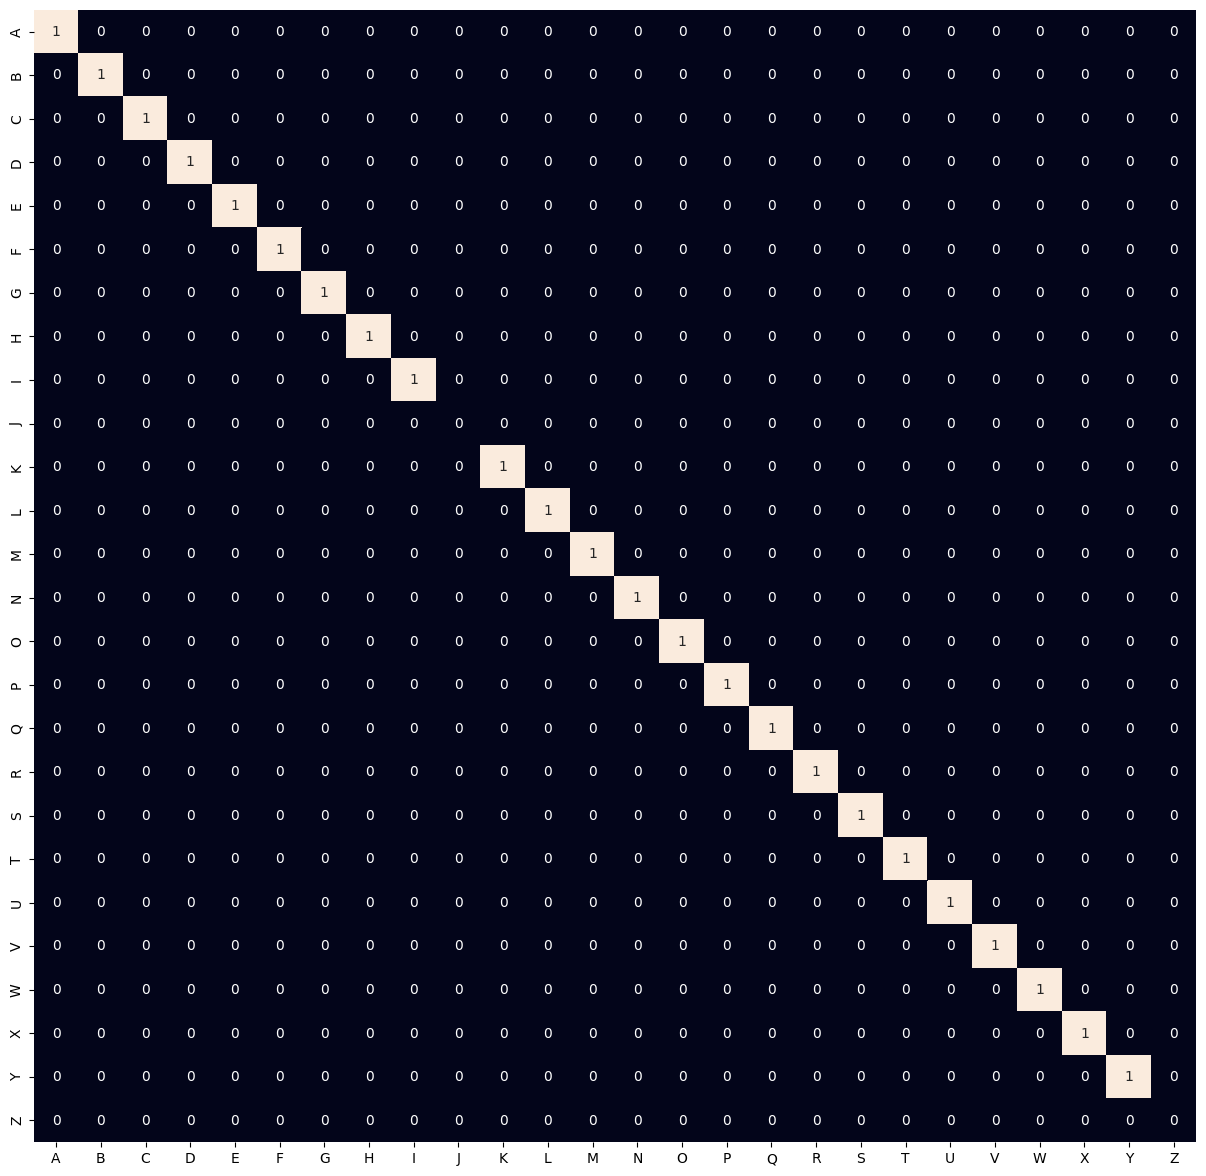

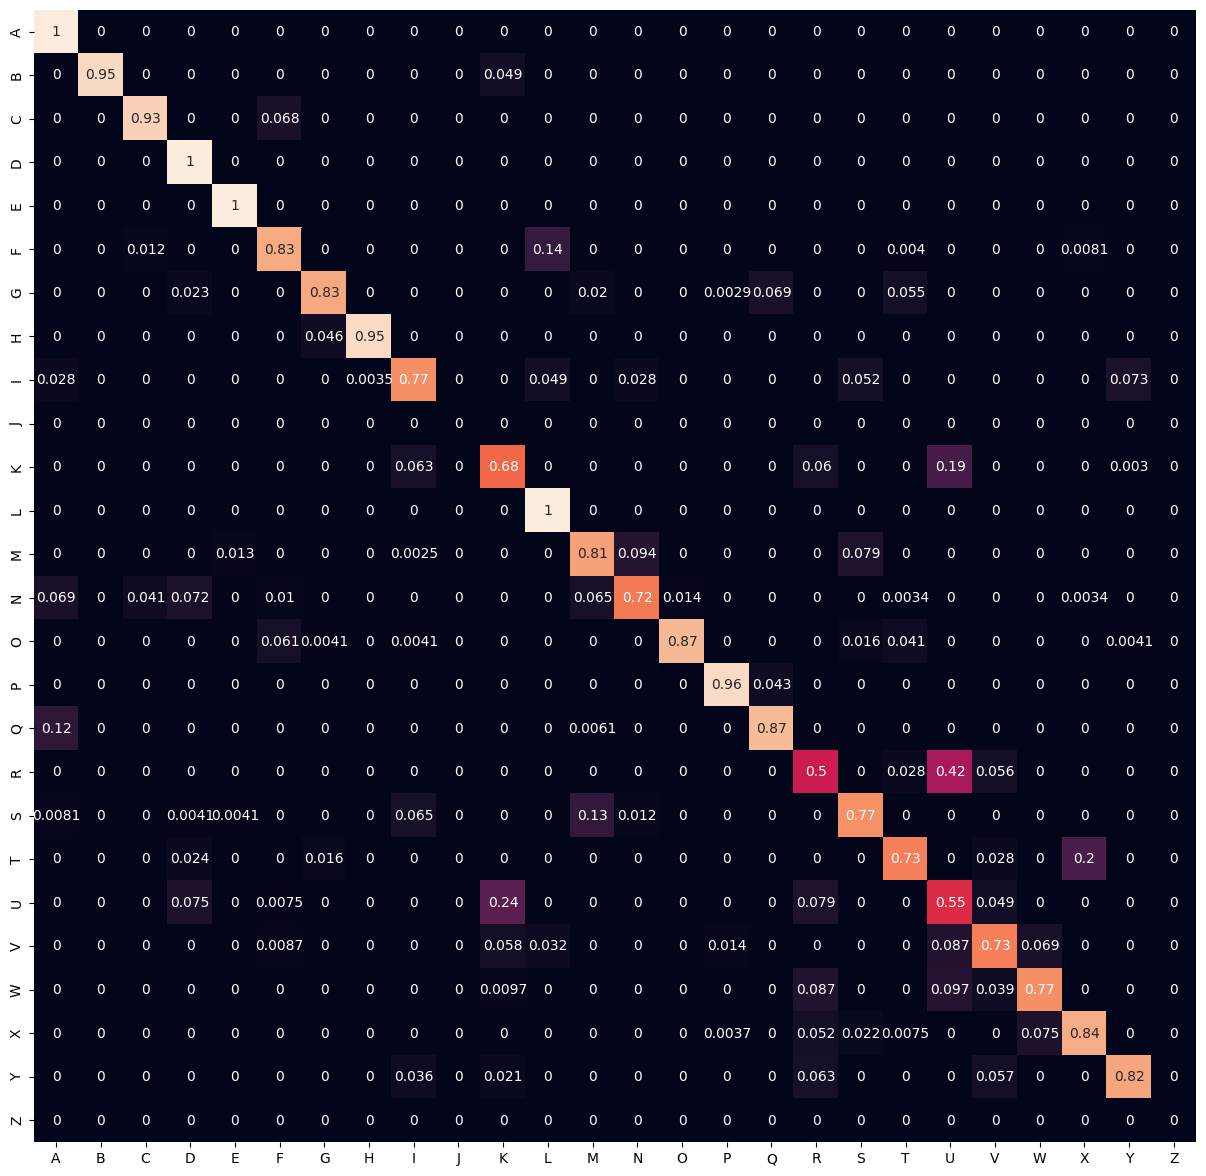

In [ ]:
tf.reset_default_graph()
input = tf.placeholder(dtype=tf.float32, shape=input_size, name='Input')
FC1 = FC('FC1', input, hidden_layer_1_size, activation='Tanh')
FC2 = FC('FC2', FC1, hidden_layer_2_size, activation='Tanh')
output = FC('Output', FC2, number_of_classes)
label = tf.placeholder(dtype=tf.float32, shape=output_size, name='Label')
loss = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=output, name='Loss'))
lr = tf.placeholder(dtype=tf.float32, shape=(), name='Learning_Rate')
adam_optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='Adam_Optimizer').minimize(loss)
saver = tf.train.Saver()
with tf.Session() as sess:
  saved_model_file = saver.restore(sess, './drive/MyDrive/DL - HW1 Practical/Saved Models/Adam_Model.ckpt')
  predicted_y_validation = np.argmax(sess.run(output, feed_dict={input: normalized_X_validation}), axis=1)
  validation_accuracy = np.mean(np.where(y_validation['label'].to_numpy()==predicted_y_validation, 1, 0))
  validation_confusion_matrix = tf.math.confusion_matrix(y_validation['label'].to_numpy(), predicted_y_validation, number_of_classes).eval().astype(np.float64)
  validation_confusion_matrix /= validation_confusion_matrix.sum(axis=1)[:,np.newaxis]
  validation_confusion_matrix = np.where(np.isnan(validation_confusion_matrix), 0, validation_confusion_matrix)
  df = pd.DataFrame(validation_confusion_matrix, index = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"], columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"])
  plt.figure(figsize=(15, 15))
  sn.heatmap(df, annot=True, cbar=False)
  print('Adam Validation Accuracy = ', validation_accuracy)
  predicted_y_test = np.argmax(sess.run(output, feed_dict={input: normalized_X_test}), axis=1)
  test_accuracy = np.mean(np.where(y_test['label'].to_numpy()==predicted_y_test, 1, 0))
  test_confusion_matrix = tf.math.confusion_matrix(y_test['label'].to_numpy(), predicted_y_test, number_of_classes).eval().astype(np.float64)
  test_confusion_matrix /= test_confusion_matrix.sum(axis=1)[:,np.newaxis]
  test_confusion_matrix = np.where(np.isnan(test_confusion_matrix), 0, test_confusion_matrix)
  df = pd.DataFrame(test_confusion_matrix, index = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"], columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"])
  plt.figure(figsize=(15, 15))
  sn.heatmap(df, annot=True, cbar=False)
  print('Adam Test Accuracy = ', test_accuracy)

Adam Algorithm is almost always faster than SGD Algorithm because of using methods which are more complex than simple moving in the opposite direction of the gradient vector. Also, because of faster convergence, it usually reaches better performance in equal number of epochs.
It is possible that other first order algorithms such as AdaGrad, RMSProp, NADAM, etc, and second order algorithms like Newton and BFGS (which have a high computational cost) be better, if parameters be adjusted properly.

C) Tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
!pkill 'tensorboard'
%tensorboard --logdir './drive/MyDrive/DL - HW1 Practical/graphs/SGD_Model'

In [ ]:
!pkill 'tensorboard'
%tensorboard --logdir './drive/MyDrive/DL - HW1 Practical/graphs/Adam_Model'

In the early epochs, because of initialization, the probability density function of weights is approximately normal dstribution with zero mean and given variance. But after training the network, the pdf of weights might change or stay unchanged so that the model be able to predict the labels correctly.

D) Dropout

In [ ]:
number_of_pixels = 28 * 28
number_of_classes = 26
input_size = (None, number_of_pixels)
hidden_layer_1_size = 500
hidden_layer_2_size = 200
output_size = (None, number_of_classes)
minibatch_size = 2500
number_of_iterations = 1000

In [ ]:
adam_constant_lr = 0.005
adam_train_loss_with_dropout = np.zeros(int(number_of_iterations/50))
tf.reset_default_graph()
input_dropout_rate = tf.placeholder(dtype=tf.float32, shape=(), name='Input_Dropout_Rate')
hidden_layers_dropout_rate = tf.placeholder(dtype=tf.float32, shape=(), name='Hidden_Layers_Dropout_Rate')
input = tf.placeholder(dtype=tf.float32, shape=input_size, name='Input')
FC1 = FC('FC1', tf.nn.dropout(input, rate=1-input_dropout_rate), hidden_layer_1_size, 0.025, 'Tanh')
FC2 = FC('FC2', tf.nn.dropout(FC1, rate=1-hidden_layers_dropout_rate), hidden_layer_2_size, 0.025, 'Tanh')
output = FC('Output', tf.nn.dropout(FC2, rate=1-hidden_layers_dropout_rate), number_of_classes, 0.025)
label = tf.placeholder(dtype=tf.float32, shape=output_size, name='Label')
loss = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=output, name='Loss'))
lr = tf.placeholder(dtype=tf.float32, shape=(), name='Learning_Rate')
adam_optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='Adam_Optimizer').minimize(loss)
saver = tf.train.Saver()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(number_of_iterations):
    random_number = np.random.randint(1e9)
    temp_X = X_train.sample(n=minibatch_size, random_state=random_number)
    normalized_temp_X = (temp_X.to_numpy() - np.mean(temp_X.to_numpy(), axis=0)) / (1e-3 + np.sqrt(np.var(temp_X.to_numpy(), axis=0)))
    noisy_normalized_temp_X = normalized_temp_X + np.random.normal(0, 1, normalized_temp_X.shape)
    temp_y = y_train.sample(n=minibatch_size, random_state=random_number)
    temp_y_one_hot = sess.run(tf.one_hot(temp_y['label'], number_of_classes))
    sess.run(adam_optimizer, feed_dict={input: noisy_normalized_temp_X, label: temp_y_one_hot, lr: adam_constant_lr/(1+i/250), input_dropout_rate: 0.8, hidden_layers_dropout_rate: 0.5})
    if (i+1)%50==0:
      adam_train_loss_with_dropout[int(i/50)] = sess.run(loss, feed_dict={input: normalized_X_train, label: y_train_one_hot, input_dropout_rate: 1, hidden_layers_dropout_rate: 1})
  saver.save(sess, './drive/MyDrive/DL - HW1 Practical/Saved Models/Adam_Model_With_Dropout.ckpt')

In [ ]:
print(adam_train_loss_with_dropout)

[0.25826624 0.08629461 0.04051033 0.0223132  0.01543257 0.01040605
 0.00809464 0.00672661 0.00503038 0.00429067 0.00352553 0.00298704
 0.00272533 0.00245018 0.00228538 0.0018948  0.00174391 0.00171353
 0.00157354 0.00142528]


INFO:tensorflow:Restoring parameters from ./drive/MyDrive/DL - HW1 Practical/Saved Models/Adam_Model_With_Dropout.ckpt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


Adam Validation Accuracy With Dropout =  1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


Adam Test Accuracy With Dropout =  0.8513664249860569


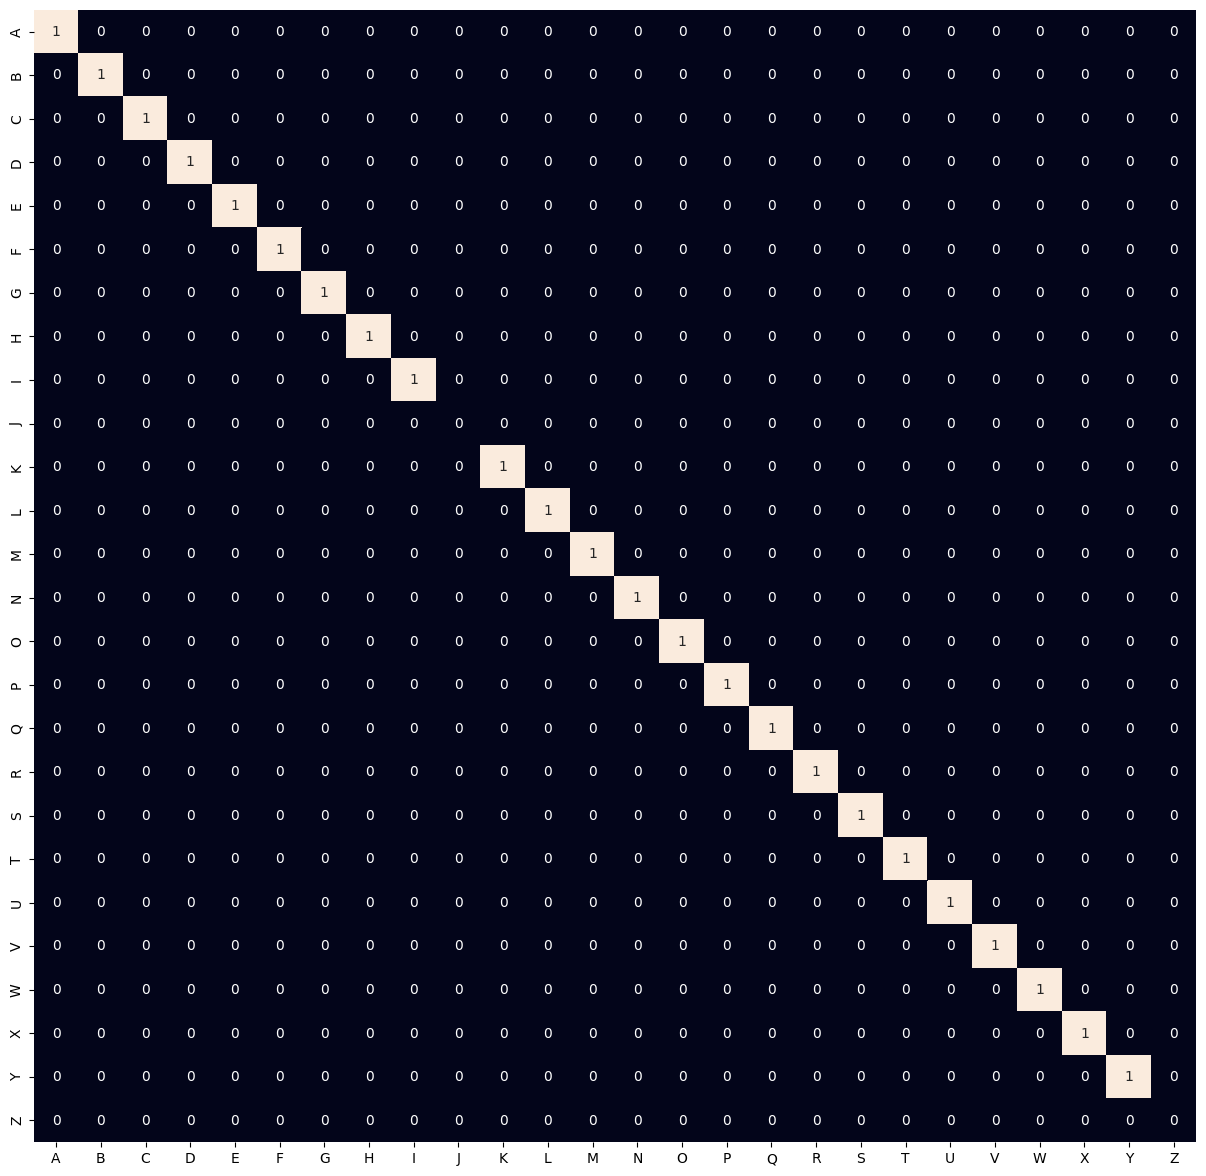

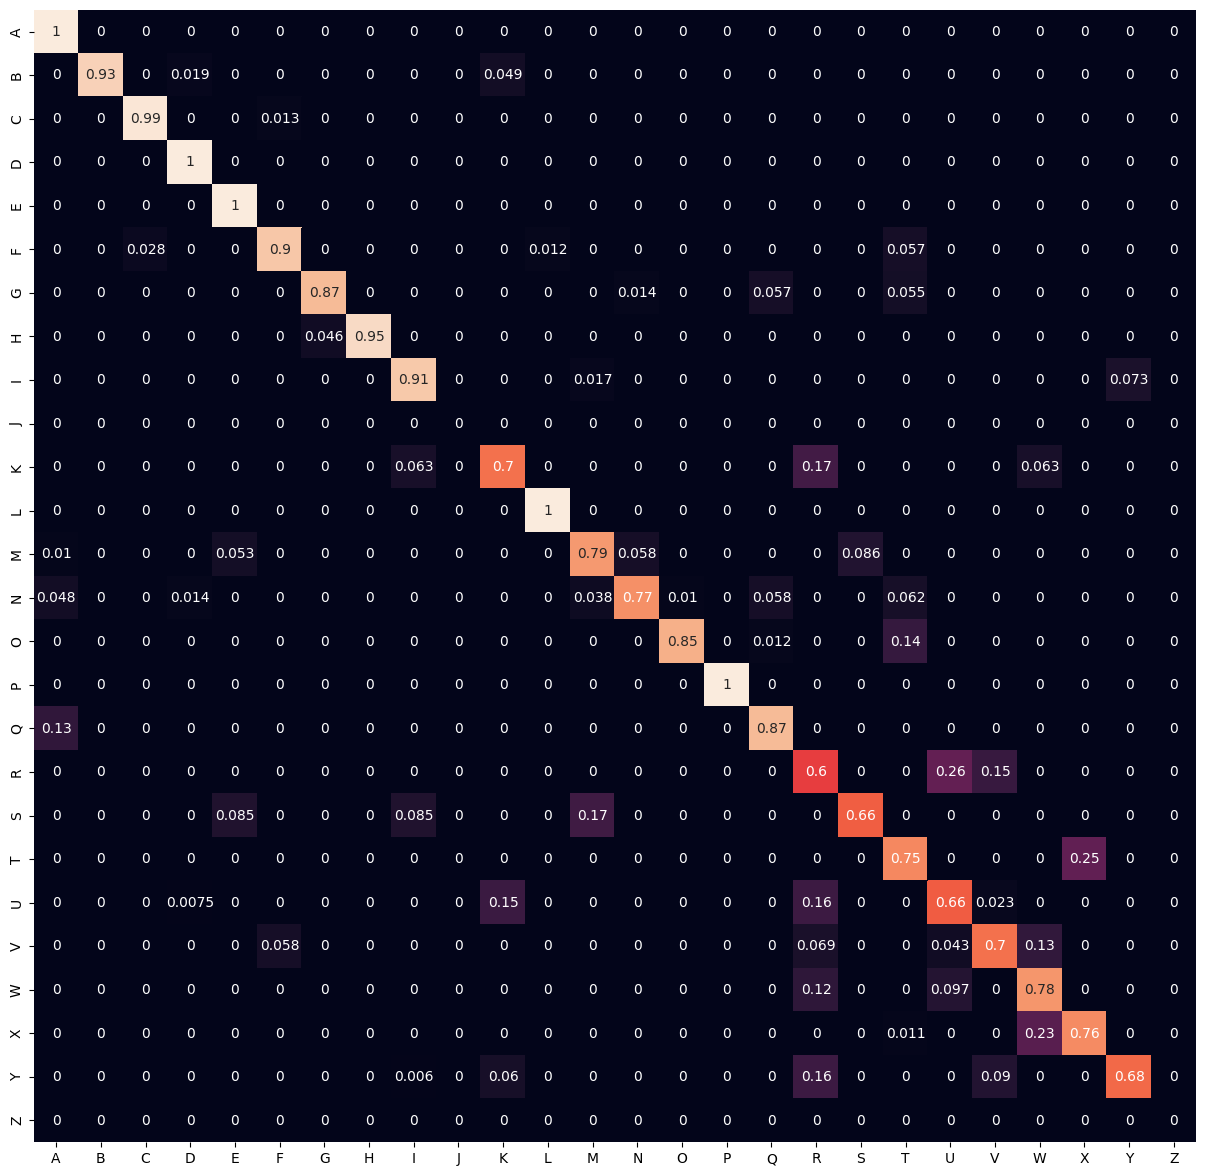

In [ ]:
tf.reset_default_graph()
input_dropout_rate = tf.placeholder(dtype=tf.float32, shape=(), name='Input_Dropout_Rate')
hidden_layers_dropout_rate = tf.placeholder(dtype=tf.float32, shape=(), name='Hidden_Layers_Dropout_Rate')
input = tf.placeholder(dtype=tf.float32, shape=input_size, name='Input')
FC1 = FC('FC1', tf.nn.dropout(input, rate=1-input_dropout_rate), hidden_layer_1_size, 0.025, 'Tanh')
FC2 = FC('FC2', tf.nn.dropout(FC1, rate=1-hidden_layers_dropout_rate), hidden_layer_2_size, 0.025, 'Tanh')
output = FC('Output', tf.nn.dropout(FC2, rate=1-hidden_layers_dropout_rate), number_of_classes, 0.025)
label = tf.placeholder(dtype=tf.float32, shape=output_size, name='Label')
loss = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=output, name='Loss'))
lr = tf.placeholder(dtype=tf.float32, shape=(), name='Learning_Rate')
adam_optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='Adam_Optimizer').minimize(loss)
saver = tf.train.Saver()
with tf.Session() as sess:
  saved_model_file = saver.restore(sess, './drive/MyDrive/DL - HW1 Practical/Saved Models/Adam_Model_With_Dropout.ckpt')
  predicted_y_validation = np.argmax(sess.run(output, feed_dict={input: normalized_X_validation, input_dropout_rate: 1, hidden_layers_dropout_rate: 1}), axis=1)
  validation_accuracy = np.mean(np.where(y_validation['label'].to_numpy()==predicted_y_validation, 1, 0))
  validation_confusion_matrix = tf.math.confusion_matrix(y_validation['label'].to_numpy(), predicted_y_validation, number_of_classes).eval().astype(np.float64)
  validation_confusion_matrix /= validation_confusion_matrix.sum(axis=1)[:,np.newaxis]
  validation_confusion_matrix = np.where(np.isnan(validation_confusion_matrix), 0, validation_confusion_matrix)
  df = pd.DataFrame(validation_confusion_matrix, index = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"], columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"])
  plt.figure(figsize=(15, 15))
  sn.heatmap(df, annot=True, cbar=False)
  print('Adam Validation Accuracy With Dropout = ', validation_accuracy)
  predicted_y_test = np.argmax(sess.run(output, feed_dict={input: normalized_X_test, input_dropout_rate: 1, hidden_layers_dropout_rate: 1}), axis=1)
  test_accuracy = np.mean(np.where(y_test['label'].to_numpy()==predicted_y_test, 1, 0))
  test_confusion_matrix = tf.math.confusion_matrix(y_test['label'].to_numpy(), predicted_y_test, number_of_classes).eval().astype(np.float64)
  test_confusion_matrix /= test_confusion_matrix.sum(axis=1)[:,np.newaxis]
  test_confusion_matrix = np.where(np.isnan(test_confusion_matrix), 0, test_confusion_matrix)
  df = pd.DataFrame(test_confusion_matrix, index = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"], columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"])
  plt.figure(figsize=(15, 15))
  sn.heatmap(df, annot=True, cbar=False)
  print('Adam Test Accuracy With Dropout = ', test_accuracy)

Using Dropout will slightly improve performance of the model on test data with increasing generalization power of the model. But since the model is not deep, it can not make much difference.

E) Batch Normalization

In [ ]:
number_of_pixels = 28 * 28
number_of_classes = 26
input_size = (None, number_of_pixels)
hidden_layer_1_size = 400
hidden_layer_2_size = 250
hidden_layer_3_size = 125
hidden_layer_4_size = 75
output_size = (None, number_of_classes)
minibatch_size = 2500
number_of_iterations = 1000

In [ ]:
adam_constant_lr = 0.005
adam_train_loss_with_dropout_and_Batch_Normalization = np.zeros(int(number_of_iterations/50))
tf.reset_default_graph()
input_dropout_rate = tf.placeholder(dtype=tf.float32, shape=(), name='Input_Dropout_Rate')
hidden_layers_dropout_rate = tf.placeholder(dtype=tf.float32, shape=(), name='Hidden_Layers_Dropout_Rate')
input = tf.placeholder(dtype=tf.float32, shape=input_size, name='Input')
FC1 = tf.layers.batch_normalization(FC('FC1', tf.nn.dropout(input, rate=1-input_dropout_rate), hidden_layer_1_size, 0.025, 'ReLU'), momentum=0.9)
FC2 = tf.layers.batch_normalization(FC('FC2', tf.nn.dropout(FC1, rate=1-hidden_layers_dropout_rate), hidden_layer_2_size, 0.025, 'ReLU'), momentum=0.9)
FC3 = tf.layers.batch_normalization(FC('FC3', tf.nn.dropout(FC2, rate=1-hidden_layers_dropout_rate), hidden_layer_3_size, 0.025, 'Tanh'), momentum=0.9)
FC4 = tf.layers.batch_normalization(FC('FC4', tf.nn.dropout(FC3, rate=1-hidden_layers_dropout_rate), hidden_layer_4_size, 0.025, 'Tanh'), momentum=0.9)
output = FC('Output', tf.nn.dropout(FC4, rate=1-hidden_layers_dropout_rate), number_of_classes, 0.025)
label = tf.placeholder(dtype=tf.float32, shape=output_size, name='Label')
loss = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=output, name='Loss'))
lr = tf.placeholder(dtype=tf.float32, shape=(), name='Learning_Rate')
adam_optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='Adam_Optimizer').minimize(loss)
saver = tf.train.Saver()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(number_of_iterations):
    random_number = np.random.randint(1e9)
    temp_X = X_train.sample(n=minibatch_size, random_state=random_number)
    normalized_temp_X = (temp_X.to_numpy() - np.mean(temp_X.to_numpy(), axis=0)) / (1e-3 + np.sqrt(np.var(temp_X.to_numpy(), axis=0)))
    noisy_normalized_temp_X = normalized_temp_X + np.random.normal(0, 1, normalized_temp_X.shape)
    temp_y = y_train.sample(n=minibatch_size, random_state=random_number)
    temp_y_one_hot = sess.run(tf.one_hot(temp_y['label'], number_of_classes))
    sess.run(adam_optimizer, feed_dict={input: noisy_normalized_temp_X, label: temp_y_one_hot, lr: adam_constant_lr/(1+i/250), input_dropout_rate: 0.8, hidden_layers_dropout_rate: 0.5})
    if (i+1)%50==0:
      adam_train_loss_with_dropout_and_Batch_Normalization[int(i/50)] = sess.run(loss, feed_dict={input: normalized_X_train, label: y_train_one_hot, input_dropout_rate: 1, hidden_layers_dropout_rate: 1})
  saver.save(sess, './drive/MyDrive/DL - HW1 Practical/Saved Models/Adam_Model_With_Dropout_and_Batch_Normalization.ckpt')

In [ ]:
print(adam_train_loss_with_dropout_and_Batch_Normalization)

[1.12485003 0.6968711  0.48779693 0.37182817 0.30648759 0.26628301
 0.23245144 0.20692281 0.17792104 0.15844341 0.14024004 0.12559009
 0.11476137 0.10121986 0.08640816 0.07787146 0.07079226 0.06253055
 0.05908442 0.05330902]


INFO:tensorflow:Restoring parameters from ./drive/MyDrive/DL - HW1 Practical/Saved Models/Adam_Model_With_Dropout_and_Batch_Normalization.ckpt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Adam Validation Accuracy With Dropout and Batch Normalization =  0.9867424242424242


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


Adam Test Accuracy With Dropout and Batch Normalization =  0.8614054656999443


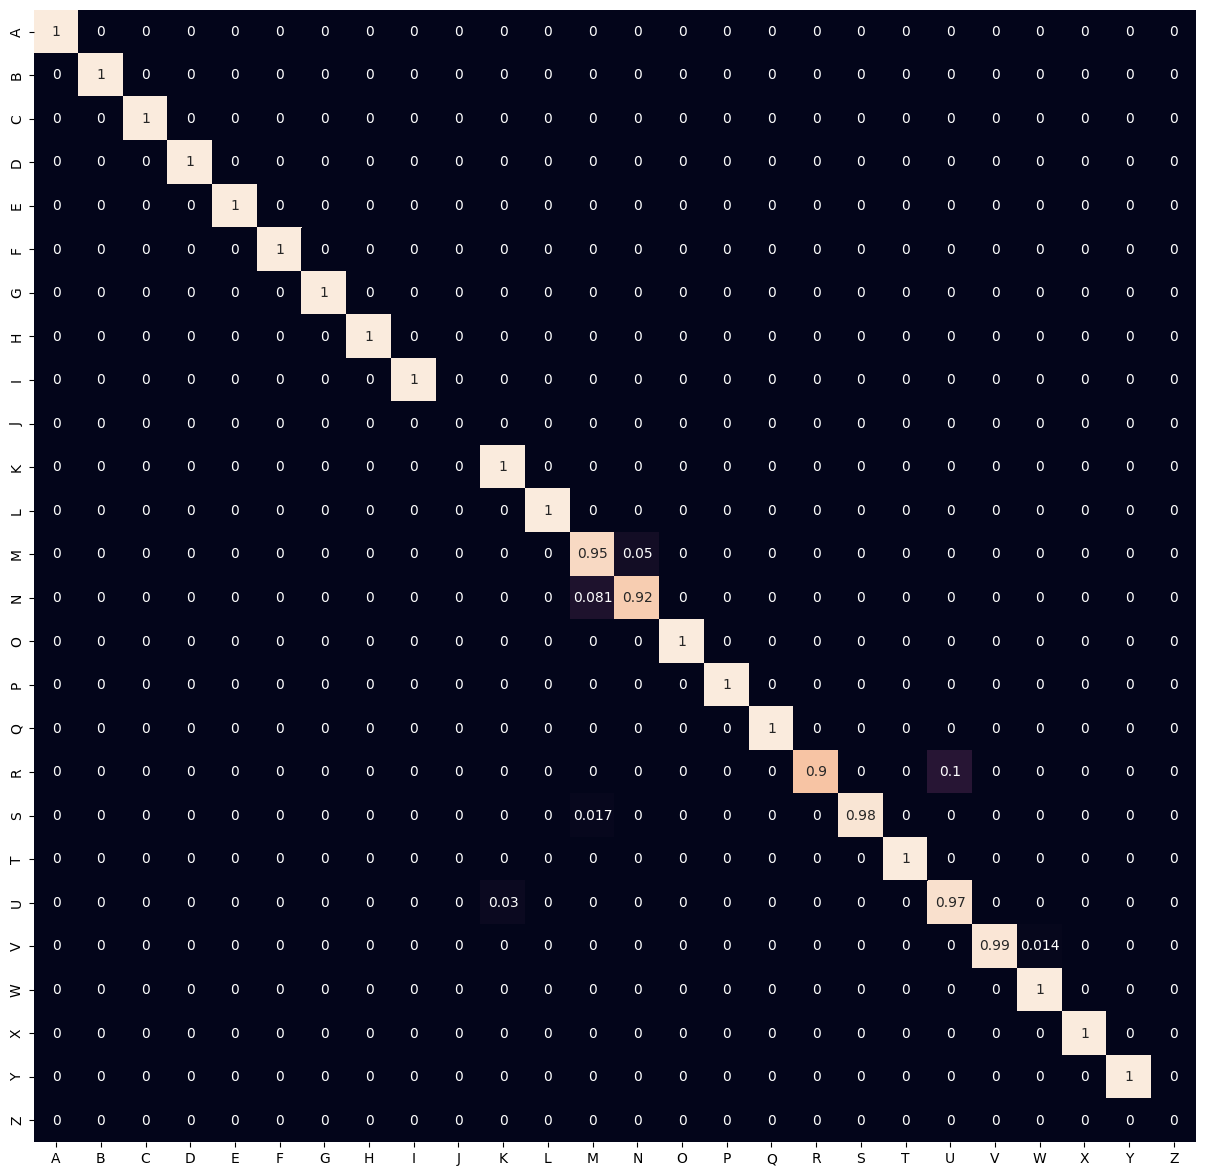

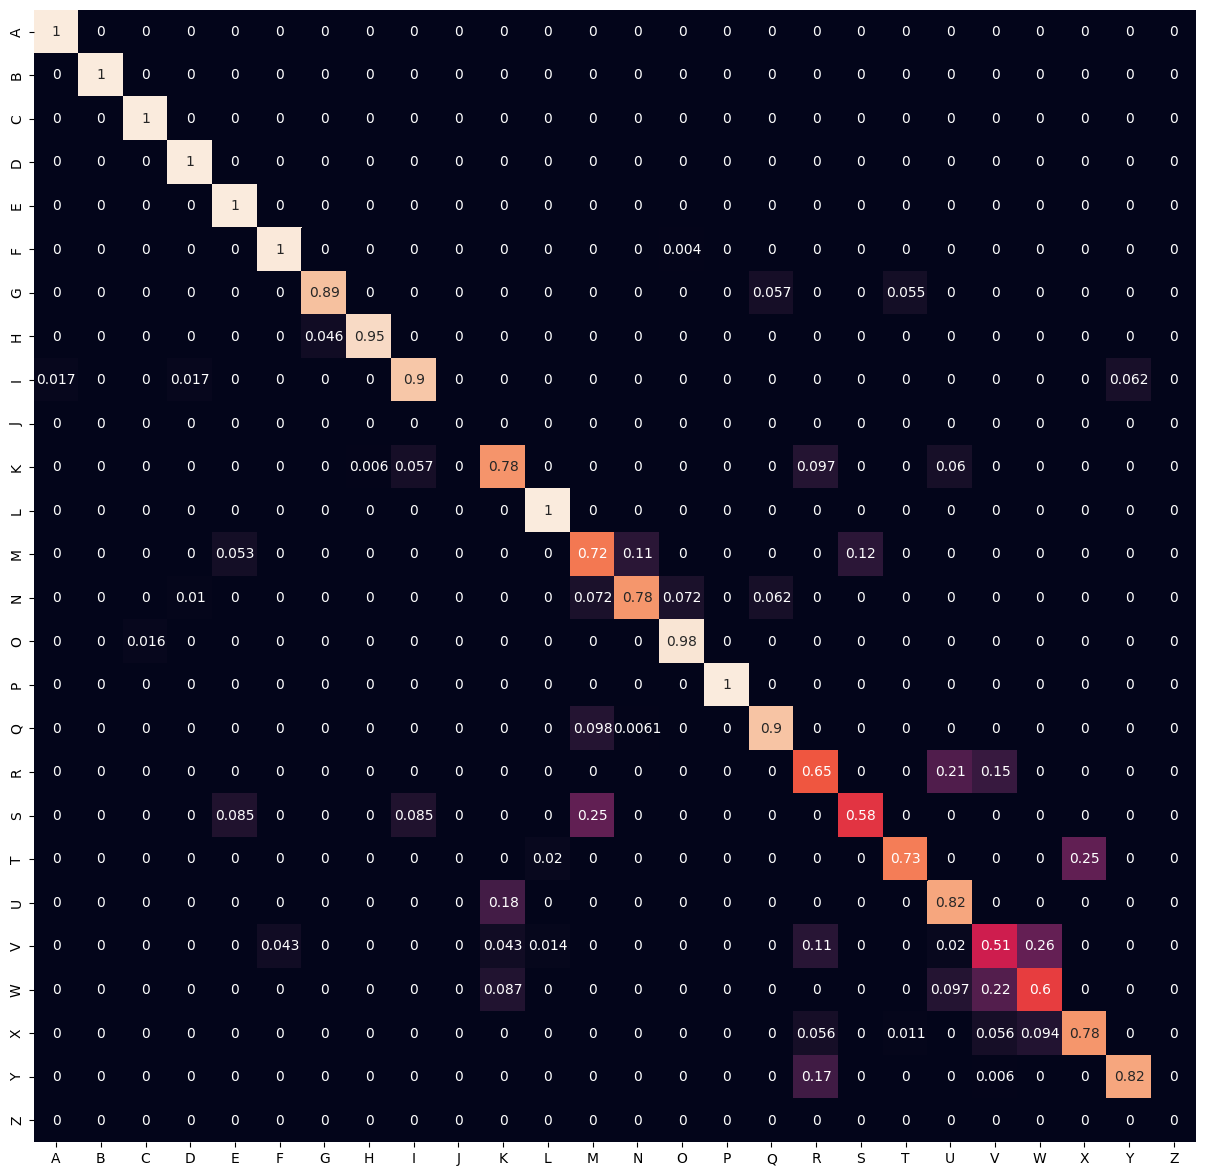

In [ ]:
tf.reset_default_graph()
input_dropout_rate = tf.placeholder(dtype=tf.float32, shape=(), name='Input_Dropout_Rate')
hidden_layers_dropout_rate = tf.placeholder(dtype=tf.float32, shape=(), name='Hidden_Layers_Dropout_Rate')
input = tf.placeholder(dtype=tf.float32, shape=input_size, name='Input')
FC1 = tf.layers.batch_normalization(FC('FC1', tf.nn.dropout(input, rate=1-input_dropout_rate), hidden_layer_1_size, 0.025, 'ReLU'), momentum=0.9)
FC2 = tf.layers.batch_normalization(FC('FC2', tf.nn.dropout(FC1, rate=1-hidden_layers_dropout_rate), hidden_layer_2_size, 0.025, 'ReLU'), momentum=0.9)
FC3 = tf.layers.batch_normalization(FC('FC3', tf.nn.dropout(FC2, rate=1-hidden_layers_dropout_rate), hidden_layer_3_size, 0.025, 'Tanh'), momentum=0.9)
FC4 = tf.layers.batch_normalization(FC('FC4', tf.nn.dropout(FC3, rate=1-hidden_layers_dropout_rate), hidden_layer_4_size, 0.025, 'Tanh'), momentum=0.9)
output = FC('Output', tf.nn.dropout(FC4, rate=1-hidden_layers_dropout_rate), number_of_classes, 0.025)
label = tf.placeholder(dtype=tf.float32, shape=output_size, name='Label')
loss = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=output, name='Loss'))
lr = tf.placeholder(dtype=tf.float32, shape=(), name='Learning_Rate')
adam_optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='Adam_Optimizer').minimize(loss)
saver = tf.train.Saver()
with tf.Session() as sess:
  saved_model_file = saver.restore(sess, './drive/MyDrive/DL - HW1 Practical/Saved Models/Adam_Model_With_Dropout_and_Batch_Normalization.ckpt')
  predicted_y_validation = np.argmax(sess.run(output, feed_dict={input: normalized_X_validation, input_dropout_rate: 1, hidden_layers_dropout_rate: 1}), axis=1)
  validation_accuracy = np.mean(np.where(y_validation['label'].to_numpy()==predicted_y_validation, 1, 0))
  validation_confusion_matrix = tf.math.confusion_matrix(y_validation['label'].to_numpy(), predicted_y_validation, number_of_classes).eval().astype(np.float64)
  validation_confusion_matrix /= validation_confusion_matrix.sum(axis=1)[:,np.newaxis]
  validation_confusion_matrix = np.where(np.isnan(validation_confusion_matrix), 0, validation_confusion_matrix)
  df = pd.DataFrame(validation_confusion_matrix, index = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"], columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"])
  plt.figure(figsize=(15, 15))
  sn.heatmap(df, annot=True, cbar=False)
  print('Adam Validation Accuracy With Dropout and Batch Normalization = ', validation_accuracy)
  predicted_y_test = np.argmax(sess.run(output, feed_dict={input: normalized_X_test, input_dropout_rate: 1, hidden_layers_dropout_rate: 1}), axis=1)
  test_accuracy = np.mean(np.where(y_test['label'].to_numpy()==predicted_y_test, 1, 0))
  test_confusion_matrix = tf.math.confusion_matrix(y_test['label'].to_numpy(), predicted_y_test, number_of_classes).eval().astype(np.float64)
  test_confusion_matrix /= test_confusion_matrix.sum(axis=1)[:,np.newaxis]
  test_confusion_matrix = np.where(np.isnan(test_confusion_matrix), 0, test_confusion_matrix)
  df = pd.DataFrame(test_confusion_matrix, index = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"], columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"])
  plt.figure(figsize=(15, 15))
  sn.heatmap(df, annot=True, cbar=False)
  print('Adam Test Accuracy With Dropout and Batch Normalization = ', test_accuracy)

Using Batch Normalization will slightly improve performance of the model on test data with increasing generalization power of the model. But since the model is not deep, it can not make much difference.

F) Unbalanced Dataset

In [ ]:
number_of_pixels = 28 * 28
number_of_classes = 26
input_size = (None, number_of_pixels)
hidden_layer_1_size = 300
hidden_layer_2_size = 100
output_size = (None, number_of_classes)
minibatch_size = 2500
number_of_iterations = 1000

In [ ]:
temp_1_X = X_train[y_train['label'] != 0]
temp_2_X = X_train[y_train['label'] == 0]
temp_1_y = y_train[y_train['label'] != 0].reset_index(drop=True)
temp_2_y = y_train[y_train['label'] == 0].reset_index(drop=True)
random_number = np.random.randint(1e9)
np.random.seed(random_number)
imbalanced_X_train = np.vstack([temp_1_X, temp_2_X.iloc[np.random.choice(range(temp_2_X.shape[0]), int(temp_2_X.shape[0]*0.1), False)]])
normalized_imbalanced_X_train = (imbalanced_X_train - np.mean(imbalanced_X_train, axis=0)) / (1e-3 + np.sqrt(np.var(imbalanced_X_train, axis=0)))
np.random.seed(random_number)
imbalanced_y_train = np.vstack([temp_1_y, temp_2_y.iloc[np.random.choice(range(temp_2_y.shape[0]), int(temp_2_y.shape[0]*0.1), False)]]).reshape(-1)
with tf.Session() as sess:
  imbalanced_y_train_one_hot = sess.run(tf.one_hot(imbalanced_y_train, number_of_classes))

In [ ]:
adam_constant_lr = 0.01
tf.reset_default_graph()
input = tf.placeholder(dtype=tf.float32, shape=input_size, name='Input')
FC1 = FC('FC1', input, hidden_layer_1_size, 0.1, 'Tanh')
FC2 = FC('FC2', FC1, hidden_layer_2_size, 0.1, 'Tanh')
output = FC('Output', FC2, number_of_classes, 0.1)
label = tf.placeholder(dtype=tf.float32, shape=output_size, name='Label')
loss = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=output, name='Loss'))
loss_tensorboard = tf.summary.scalar('Loss_tensorboard', loss)
lr = tf.placeholder(dtype=tf.float32, shape=(), name='Learning_Rate')
adam_optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='Adam_Optimizer').minimize(loss)
saver = tf.train.Saver()
with tf.Session() as sess:
  !rm -rf './drive/MyDrive/DL - HW1 Practical/graphs/Imbalanced_Adam_Model'
  writer = tf.summary.FileWriter('./drive/MyDrive/DL - HW1 Practical/graphs/Imbalanced_Adam_Model', sess.graph)
  summaries = tf.summary.merge_all()
  sess.run(tf.global_variables_initializer())
  for i in range(number_of_iterations):
    random_number = np.random.randint(1e9)
    np.random.seed(random_number)
    temp_X = imbalanced_X_train[np.random.choice(range(imbalanced_X_train.shape[0]), minibatch_size, False)]
    normalized_temp_X = (temp_X - np.mean(temp_X, axis=0)) / (1e-3 + np.sqrt(np.var(temp_X, axis=0)))
    noisy_normalized_temp_X = normalized_temp_X + np.random.normal(0, 1, normalized_temp_X.shape)
    np.random.seed(random_number)
    temp_y = imbalanced_y_train[np.random.choice(range(imbalanced_X_train.shape[0]), minibatch_size, False)]
    temp_y_one_hot = sess.run(tf.one_hot(temp_y, number_of_classes))
    sess.run(adam_optimizer, feed_dict={input: noisy_normalized_temp_X, label: temp_y_one_hot, lr: adam_constant_lr/(1+i/250)})
    if (i+1)%10==0:
      writer.add_summary(sess.run(summaries, feed_dict={input: normalized_imbalanced_X_train, label: imbalanced_y_train_one_hot}), global_step=(i+1)/10)
  saver.save(sess, './drive/MyDrive/DL - HW1 Practical/Saved Models/Imbalanced_Adam_Model.ckpt')

INFO:tensorflow:Restoring parameters from ./drive/MyDrive/DL - HW1 Practical/Saved Models/Imbalanced_Adam_Model.ckpt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Imbalanced Adam Validation Accuracy =  1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


Imbalanced Adam Test Accuracy =  0.8353318460680423


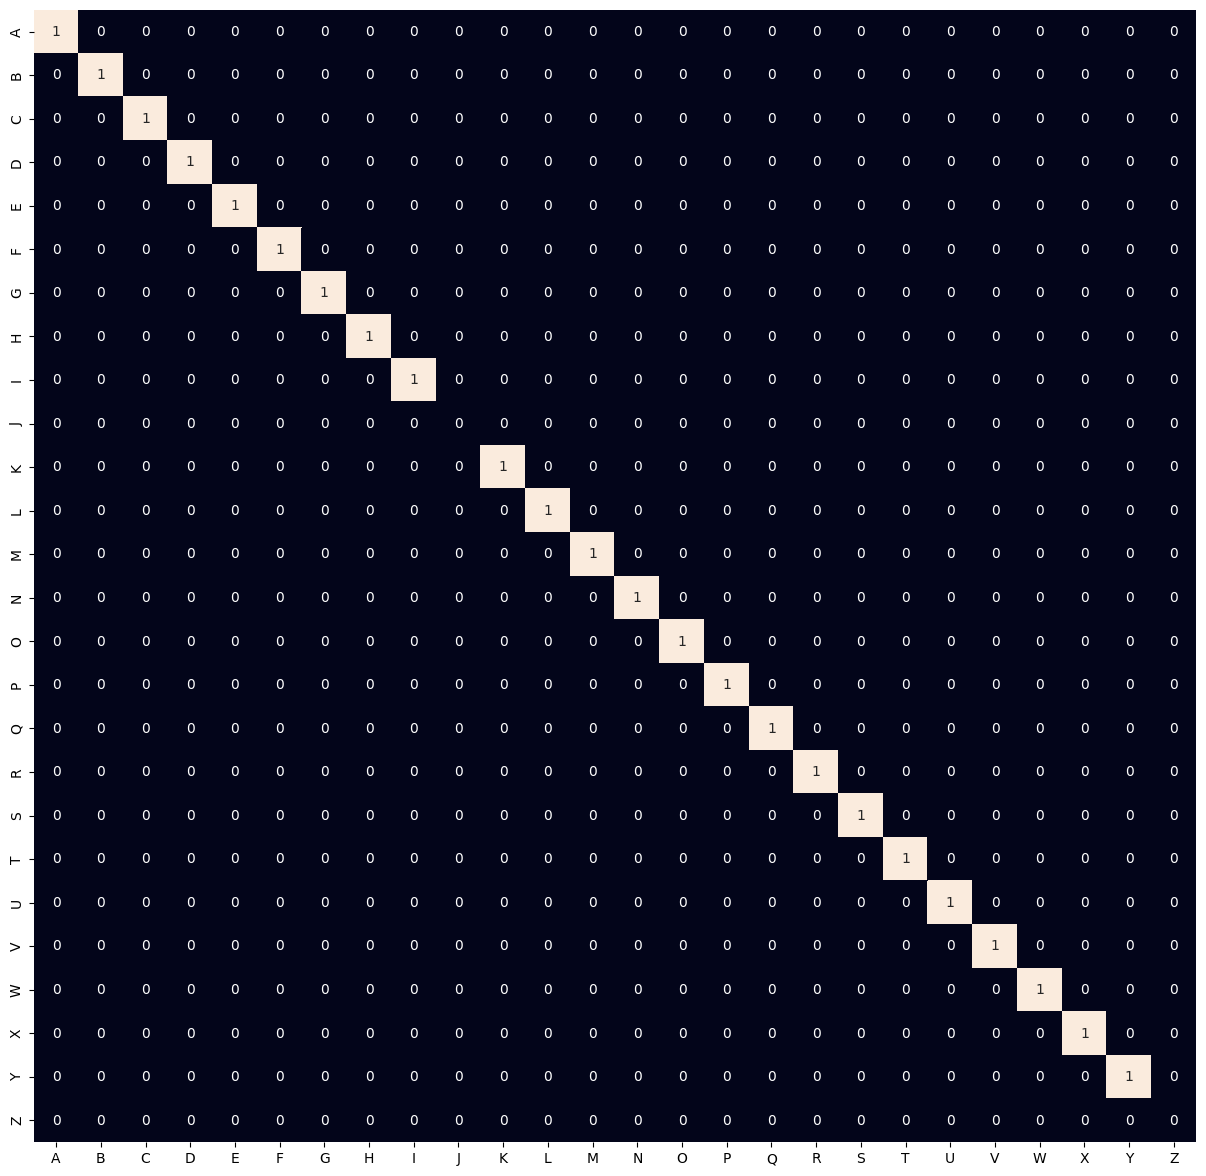

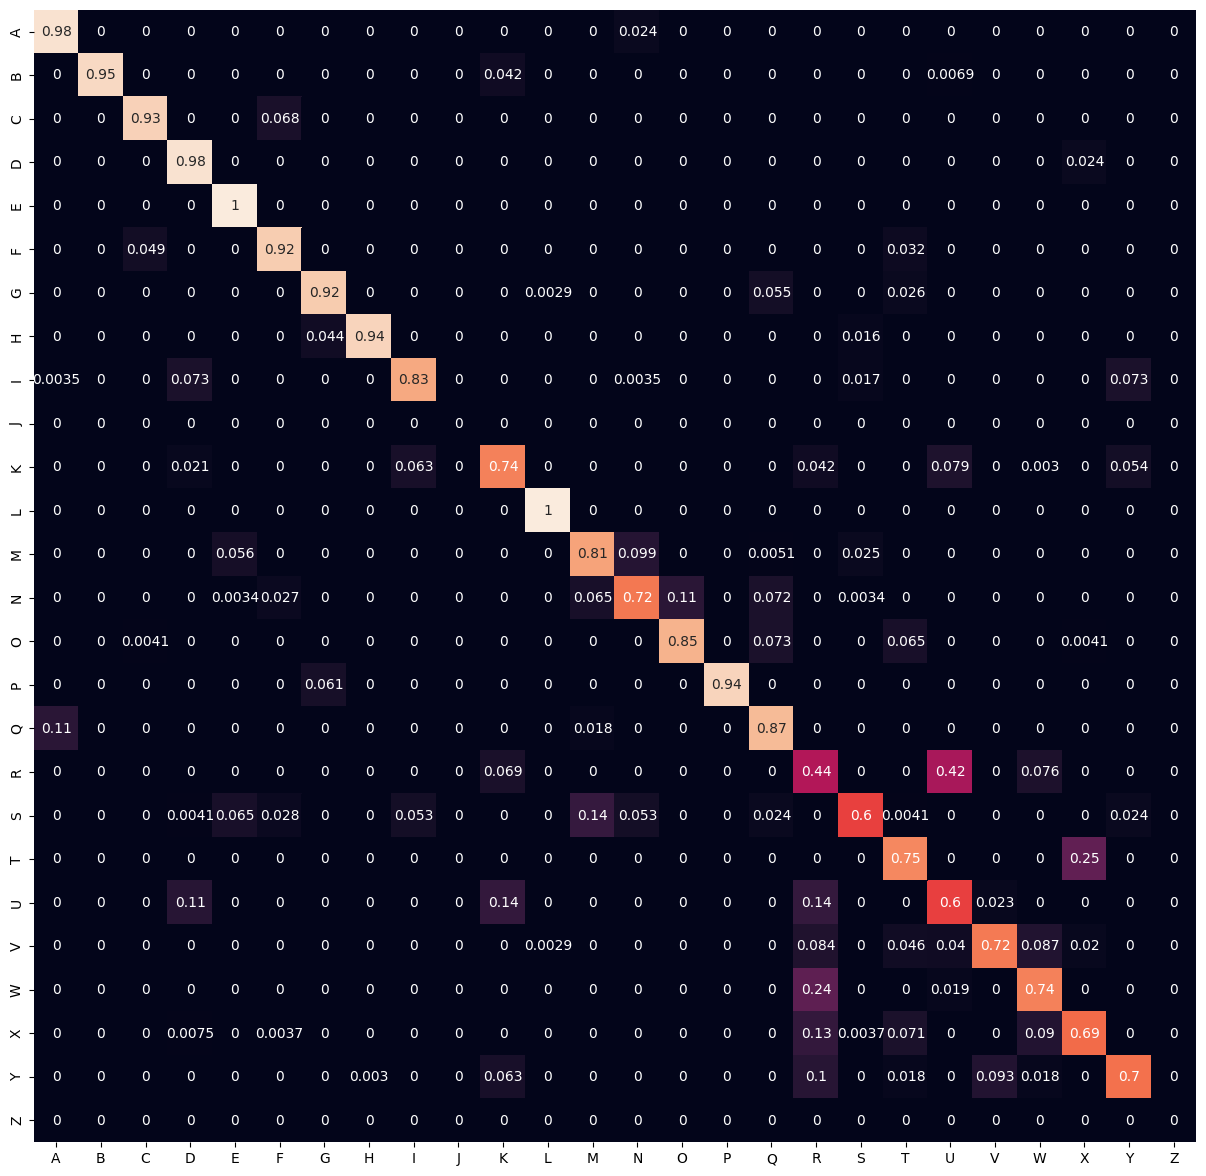

In [ ]:
tf.reset_default_graph()
input = tf.placeholder(dtype=tf.float32, shape=input_size, name='Input')
FC1 = FC('FC1', input, hidden_layer_1_size, activation='Tanh')
FC2 = FC('FC2', FC1, hidden_layer_2_size, activation='Tanh')
output = FC('Output', FC2, number_of_classes)
label = tf.placeholder(dtype=tf.float32, shape=output_size, name='Label')
loss = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=output, name='Loss'))
lr = tf.placeholder(dtype=tf.float32, shape=(), name='Learning_Rate')
adam_optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='Adam_Optimizer').minimize(loss)
saver = tf.train.Saver()
with tf.Session() as sess:
  saved_model_file = saver.restore(sess, './drive/MyDrive/DL - HW1 Practical/Saved Models/Imbalanced_Adam_Model.ckpt')
  predicted_y_validation = np.argmax(sess.run(output, feed_dict={input: normalized_X_validation}), axis=1)
  validation_accuracy = np.mean(np.where(y_validation['label'].to_numpy()==predicted_y_validation, 1, 0))
  validation_confusion_matrix = tf.math.confusion_matrix(y_validation['label'].to_numpy(), predicted_y_validation, number_of_classes).eval().astype(np.float64)
  validation_confusion_matrix /= validation_confusion_matrix.sum(axis=1)[:,np.newaxis]
  validation_confusion_matrix = np.where(np.isnan(validation_confusion_matrix), 0, validation_confusion_matrix)
  df = pd.DataFrame(validation_confusion_matrix, index = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"], columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"])
  plt.figure(figsize=(15, 15))
  sn.heatmap(df, annot=True, cbar=False)
  print('Imbalanced Adam Validation Accuracy = ', validation_accuracy)
  predicted_y_test = np.argmax(sess.run(output, feed_dict={input: normalized_X_test}), axis=1)
  test_accuracy = np.mean(np.where(y_test['label'].to_numpy()==predicted_y_test, 1, 0))
  test_confusion_matrix = tf.math.confusion_matrix(y_test['label'].to_numpy(), predicted_y_test, number_of_classes).eval().astype(np.float64)
  test_confusion_matrix /= test_confusion_matrix.sum(axis=1)[:,np.newaxis]
  test_confusion_matrix = np.where(np.isnan(test_confusion_matrix), 0, test_confusion_matrix)
  df = pd.DataFrame(test_confusion_matrix, index = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"], columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"])
  plt.figure(figsize=(15, 15))
  sn.heatmap(df, annot=True, cbar=False)
  print('Imbalanced Adam Test Accuracy = ', test_accuracy)

Reducing number of samples of a class in train data will make the dataset imbalanced and weaken performance of the model on that class.
The following techniques can help to train a classifier with imbalanced dataset.
1) Resample the training set: Two approaches to make a balanced dataset out of an imbalanced one are under-sampling and over-sampling. Under-sampling balances the dataset by reducing the size of the abundant classes, and on the contrary, oversampling is used when the quantity of data is insufficient. Data Augmentation is one of the best ways for oversampling.
2) Ensemble different resampled datasets and resample with different ratios: One good method to deal with imbalanced datasets is building n models that use all the samples of the rare class and n-differing samples of the abundant classes. It can be fine-tuned by playing with the ratio between the rare and the abundant class.

G) Webcam

In [ ]:
number_of_pixels = 28 * 28
number_of_classes = 26
input_size = (None, number_of_pixels)
hidden_layer_1_size = 400
hidden_layer_2_size = 250
hidden_layer_3_size = 125
hidden_layer_4_size = 75
output_size = (None, number_of_classes)
minibatch_size = 2500
number_of_iterations = 1000

In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
from io import BytesIO
from PIL import Image

VIDEO_HTML = """
<div class="video_container">
  <video autoplay width=%d height=%d></video>
</div>
<script>
var video = document.querySelector('video')
navigator.mediaDevices.getUserMedia({video: true}).then(stream=> video.srcObject = stream)

function data() {
    var video = document.querySelector('video')
    var canvas = document.createElement('canvas')
    var [w,h] = [video.videoWidth, video.videoHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d').drawImage(video, 0, 0, w, h)
    return canvas.toDataURL('image/jpeg', %f)
  }
</script>
"""

def stream(filename=None, quality=1, size=(640, 480)):
  handle = display(HTML(VIDEO_HTML % (size[0],size[1],quality)), display_id='videoHTML')

stream()

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from io import BytesIO
from PIL import Image
import cv2

def take_photo(quality=1):
  js = Javascript('''
    async function takePhoto(quality) {
      const video = document.createElement('video');
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;
      await video.play();
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth
      canvas.height = video.videoHeight
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      return canvas.toDataURL();
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  print(data)
  img_bytes = b64decode(data.split(',')[1])
  img = Image.open(BytesIO(img_bytes))
  img = np.array(img)
  img = img[0:400, 0:400, :]
  img = cv2.resize(img, dsize=(28, 28))
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return gray_img

In [ ]:
gray_img = take_photo()
gray_img = (gray_img.reshape(1, -1) - np.mean(X_test.to_numpy(), axis=0)) / (1e-3 + np.sqrt(np.var(X_test.to_numpy(), axis=0)))
tf.reset_default_graph()
input_dropout_rate = tf.placeholder(dtype=tf.float32, shape=(), name='Input_Dropout_Rate')
hidden_layers_dropout_rate = tf.placeholder(dtype=tf.float32, shape=(), name='Hidden_Layers_Dropout_Rate')
input = tf.placeholder(dtype=tf.float32, shape=input_size, name='Input')
FC1 = tf.layers.batch_normalization(FC('FC1', tf.nn.dropout(input, rate=1-input_dropout_rate), hidden_layer_1_size, 0.025, 'ReLU'), momentum=0.9)
FC2 = tf.layers.batch_normalization(FC('FC2', tf.nn.dropout(FC1, rate=1-hidden_layers_dropout_rate), hidden_layer_2_size, 0.025, 'ReLU'), momentum=0.9)
FC3 = tf.layers.batch_normalization(FC('FC3', tf.nn.dropout(FC2, rate=1-hidden_layers_dropout_rate), hidden_layer_3_size, 0.025, 'Tanh'), momentum=0.9)
FC4 = tf.layers.batch_normalization(FC('FC4', tf.nn.dropout(FC3, rate=1-hidden_layers_dropout_rate), hidden_layer_4_size, 0.025, 'Tanh'), momentum=0.9)
output = FC('Output', tf.nn.dropout(FC4, rate=1-hidden_layers_dropout_rate), number_of_classes, 0.025)
label = tf.placeholder(dtype=tf.float32, shape=output_size, name='Label')
loss = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=output, name='Loss'))
lr = tf.placeholder(dtype=tf.float32, shape=(), name='Learning_Rate')
adam_optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='Adam_Optimizer').minimize(loss)
saver = tf.train.Saver()
with tf.Session() as sess:
  saved_model_file = saver.restore(sess, './drive/MyDrive/DL - HW1 Practical/Saved Models/Adam_Model_With_Dropout_and_Batch_Normalization.ckpt')
  predicted_y = sess.run(output, feed_dict={input: gray_img, input_dropout_rate: 1, hidden_layers_dropout_rate: 1})
  print(predicted_y)
  print(chr(np.argmax(predicted_y, axis=1) + 65))

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import cv2
import scipy
vid = cv2.VideoCapture(0)
tf.reset_default_graph()
input_dropout_rate = tf.placeholder(dtype=tf.float32, shape=(), name='Input_Dropout_Rate')
hidden_layers_dropout_rate = tf.placeholder(dtype=tf.float32, shape=(), name='Hidden_Layers_Dropout_Rate')
input = tf.placeholder(dtype=tf.float32, shape=input_size, name='Input')
FC1 = tf.layers.batch_normalization(FC('FC1', tf.nn.dropout(input, rate=1-input_dropout_rate), hidden_layer_1_size, 0.025, 'ReLU'), momentum=0.9)
FC2 = tf.layers.batch_normalization(FC('FC2', tf.nn.dropout(FC1, rate=1-hidden_layers_dropout_rate), hidden_layer_2_size, 0.025, 'ReLU'), momentum=0.9)
FC3 = tf.layers.batch_normalization(FC('FC3', tf.nn.dropout(FC2, rate=1-hidden_layers_dropout_rate), hidden_layer_3_size, 0.025, 'Tanh'), momentum=0.9)
FC4 = tf.layers.batch_normalization(FC('FC4', tf.nn.dropout(FC3, rate=1-hidden_layers_dropout_rate), hidden_layer_4_size, 0.025, 'Tanh'), momentum=0.9)
output = FC('Output', tf.nn.dropout(FC4, rate=1-hidden_layers_dropout_rate), number_of_classes, 0.025)
label = tf.placeholder(dtype=tf.float32, shape=output_size, name='Label')
loss = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=output, name='Loss'))
lr = tf.placeholder(dtype=tf.float32, shape=(), name='Learning_Rate')
adam_optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='Adam_Optimizer').minimize(loss)
saver = tf.train.Saver()    
with tf.Session() as sess:
  saved_model_file = saver.restore(sess, './drive/MyDrive/DL - HW1 Practical/Saved Models/Adam_Model_With_Dropout_and_Batch_Normalization.ckpt')
  while(True): 
    ret, frame = vid.read()
    frame = frame[0:400, 0:400, :]
    img = cv2.resize(frame, dsize=(28, 28))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_img = (gray_img.reshape(1, -1) - np.mean(X_test.to_numpy(), axis=0)) / (1e-3 + np.sqrt(np.var(X_test.to_numpy(), axis=0)))
    predicted_y = sess.run(output, feed_dict={input: gray_img, input_dropout_rate: 1, hidden_layers_dropout_rate: 1})
    cv2.putText(frame, chr(int(np.argmax(predicted_y, axis=1)) + 65) + ': ' + str(scipy.special.softmax(predicted_y)[0][int(np.argmax(predicted_y, axis=1))]), (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
      cv2.imwrite(chr(int(np.argmax(predicted_y, axis=1)) + 65) + '.jpg', frame)
      break
vid.release()
cv2.destroyAllWindows()